# Population Prediction using PCA and Random Forests

In [1]:
library("gdsfmt")
library("SNPRelate")
library("randomForest")

SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


## Input/Output Files

In [2]:
# input files
vcf.1 = "out.recode.vcf"
label.file = "integrated_call_samples_v3.20130502.ALL.panel"
# output files
gds.1 = "out.recode.gds"
output.loading.file = "output.loading.mat.txt"

## Parameters

In [3]:
# parameters
percent.train = 0.7
num.threads = 44
num.eigenvectors = 5
# params for LD pruning
ld.threshold = 0.2
slide.max.bp = 100

In [4]:
sample.info = read.table(label.file, header=TRUE, sep="\t")
head(sample.info)
pop_code = sample.info$super_pop

sample,pop,super_pop,gender
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male
HG00102,GBR,EUR,female


In [5]:
# if GDS file does not exist, we need to create
if (!file.exists(gds.1)) {
    print("GDS file does not exist! Creating...")
    snpgdsVCF2GDS(vcf.1, gds.1, method="biallelic.only")
}

In [6]:
genofile.maf = snpgdsOpen(gds.1)
set.seed(1000)

## run LD pruning 

In [7]:
snpset.maf = snpgdsLDpruning(genofile.maf, ld.threshold=ld.threshold, slide.max.bp=slide.max.bp, num.thread=44)
snpset.id = unlist(snpset.maf)

SNP pruning based on LD:
Excluding 1,832,390 SNPs on non-autosomes
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
Working space: 2,504 samples, 38,933 SNPs
    using 44 (CPU) cores


Warning message in snpgdsLDpruning(genofile.maf, ld.threshold = ld.threshold, slide.max.bp = slide.max.bp, :
“The current version of 'snpgdsLDpruning()' does not support multi-threading.”

    sliding window: 100 basepairs, Inf SNPs
    |LD| threshold: 0.2
    method: composite
Chromosome 1: 99.87%, 3,942/3,947
Chromosome 2: 100.00%, 2,668/2,668
Chromosome 3: 99.91%, 2,158/2,160
Chromosome 4: 99.83%, 1,783/1,786
Chromosome 5: 99.95%, 1,820/1,821
Chromosome 6: 99.90%, 2,064/2,066
Chromosome 7: 99.95%, 2,058/2,059
Chromosome 8: 100.00%, 1,587/1,587
Chromosome 9: 100.00%, 1,732/1,732
Chromosome 10: 99.94%, 1,788/1,789
Chromosome 11: 99.82%, 2,195/2,199
Chromosome 12: 99.91%, 2,160/2,162
Chromosome 13: 100.00%, 860/860
Chromosome 14: 100.00%, 1,329/1,329
Chromosome 15: 100.00%, 1,336/1,336
Chromosome 16: 99.87%, 1,510/1,512
Chromosome 17: 99.80%, 2,000/2,004
Chromosome 18: 100.00%, 784/784
Chromosome 19: 99.96%, 2,547/2,548
Chromosome 20: 100.00%, 1,106/1,106
Chromosome 21: 100.00%, 536/536
Chromosome 22: 99.89%, 941/942
38,904 markers are selected in total.


In [8]:
head(snpset.id)
length(snpset.maf)

chr11 chr12 chr13 chr14 chr15 chr16 
    1     2     3     4     5     6

[1] 22

## Split data into training and testing sets
We split the dataset into a training set (70% of input data) and a testing set (30% of input data) using random sampling. 

In [9]:
# get list of training examples by randomly sampling 
sample.id = read.gdsn(index.gdsn(genofile.maf, "sample.id"))
num.training.samples = round(percent.train * length(sample.id))
training.samples = sample(sample.id, num.training.samples)
print(sprintf("number of training samples: %d", num.training.samples))

[1] "number of training samples: 1753"


In [10]:
# use others for testing
testing.samples = sample.id[!(sample.id %in% training.samples)]
num.testing.samples = length(testing.samples)
print(sprintf("number of testing samples: %d", num.testing.samples))

[1] "number of testing samples: 751"


## Run PCA
Using the training samples, and the set of SNPs that passed the LD filtering step, we run PCA using the [SNPRelate](https://bioconductor.org/packages/release/bioc/html/SNPRelate.html) package. This function allows us to use multiple threads for faster processing.

In [11]:
pca = snpgdsPCA(genofile.maf, sample.id=training.samples, snp.id=snpset.id, num.thread=num.threads)

Principal Component Analysis (PCA) on genotypes:
Excluding 1,832,419 SNPs (non-autosomes or non-selection)
Excluding 56 SNPs (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
Working space: 1,753 samples, 38,848 SNPs
    using 44 (CPU) cores
PCA:    the sum of all selected genotypes (0,1,2) = 117421474
CPU capabilities: Double-Precision SSE2
Wed Feb 14 19:31:07 2018    (internal increment: 4088)
[==================================================] 100%, completed in 2s
Wed Feb 14 19:31:09 2018    Begin (eigenvalues and eigenvectors)
Wed Feb 14 19:31:10 2018    Done.


In [12]:
pc.percent = pca$varprop*100 
head(round(pc.percent, num.eigenvectors))

[1] 5.13035 2.13858 0.94520 0.70776 0.24253 0.19790

## Plot first eigenvector against second eigenvector

sample.id,pop,EV1,EV2
HG00096,EUR,-0.01420919,-0.03220898
HG00097,EUR,-0.01439446,-0.03315992
HG00099,EUR,-0.01406508,-0.03041370
HG00101,EUR,-0.01465051,-0.03090519
HG00105,EUR,-0.01466542,-0.03215562
HG00106,EUR,-0.01454321,-0.03003230


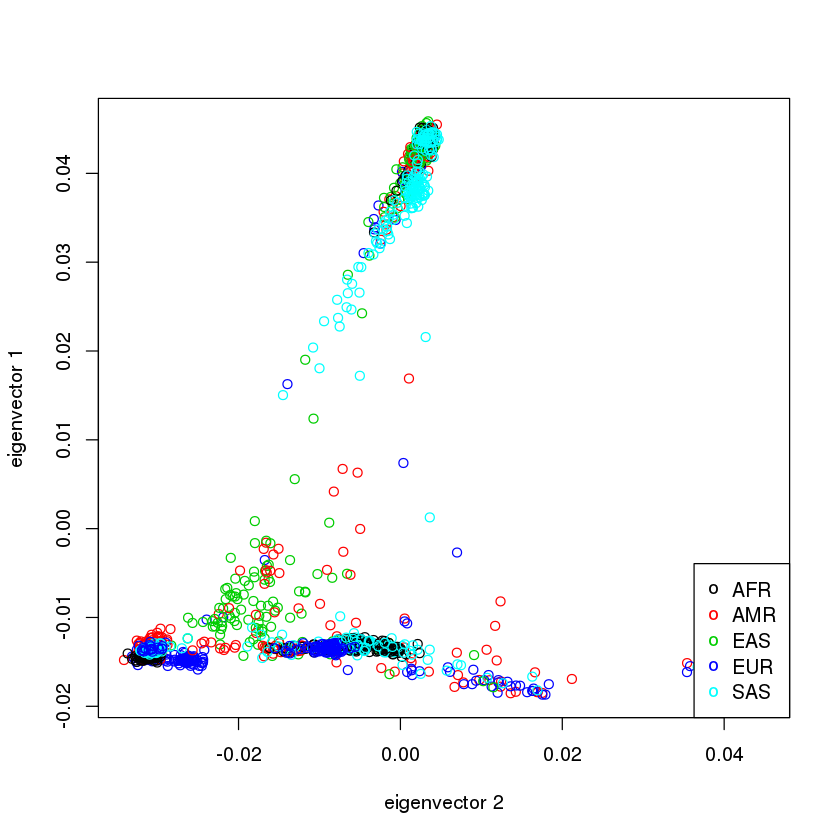

In [14]:
tab <- data.frame(sample.id=pca$sample.id, pop=factor(pop_code)[match(pca$sample.id, pca$sample.id)], EV1=pca$eigenvect[,1], EV2=pca$eigenvect[,2], stringsAsFactors=FALSE)
head(tab)
plot(tab$EV2, tab$EV1, col=as.integer(tab$pop), xlab="eigenvector 2", ylab="eigenvector 1")
legend("bottomright", legend=levels(tab$pop), pch="o", col=1:nlevels(tab$pop))

## Plot top 5 PCs against each other 

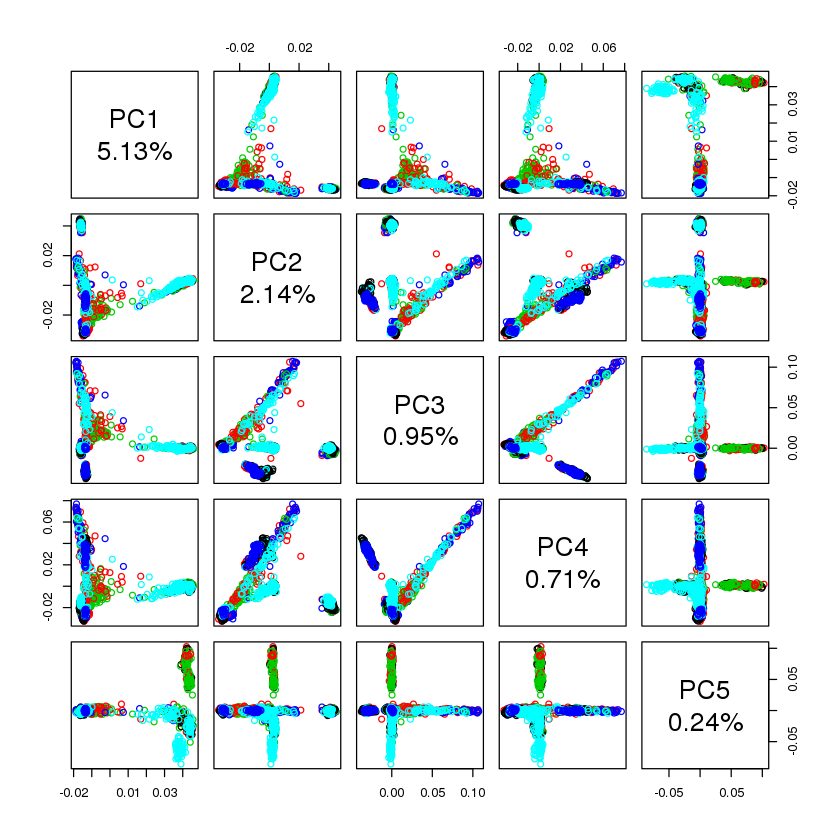

In [15]:
lbls <- paste("PC", 1:num.eigenvectors, "\n", format(pc.percent[1:num.eigenvectors], digits=2), "%", sep="")
pairs(pca$eigenvect[,1:num.eigenvectors], col=tab$pop, labels=lbls)

## Calculate SNP loadings 

In [16]:
# get SNP loadings 
snp.loadings = snpgdsPCASNPLoading(pca, genofile.maf, num.thread=num.threads)

SNP loading:
Working space: 1753 samples, 38848 SNPs
    using 44 (CPU) cores
    using the top 32 eigenvectors
SNP Loading:    the sum of all selected genotypes (0,1,2) = 117421474
Wed Feb 14 19:31:12 2018    (internal increment: 32728)
[==================================================] 100%, completed in 0s
Wed Feb 14 19:31:12 2018    Done.


## Calculate sample loadings for testing set using SNP loadings

In [17]:
# get sample loadings
sample.loadings = snpgdsPCASampLoading(snp.loadings, genofile.maf, sample.id=testing.samples, num.thread=num.threads)

Sample loading:
Working space: 751 samples, 38848 SNPs
    using 44 (CPU) cores
    using the top 32 eigenvectors
Sample Loading:    the sum of all selected genotypes (0,1,2) = 50285171
Wed Feb 14 19:31:13 2018    (internal increment: 65536)
[==================================================] 100%, completed in 0s
Wed Feb 14 19:31:13 2018    Done.


In [18]:
# extract list of SNPs used in PCA
snp.list = snpgdsSNPList(genofile.maf)
snp.rs.id = snp.list$rs.id[snpset.id]
snp.chrom = snp.list$chromosome[snpset.id]
snp.pos = snp.list$position[snpset.id]

In [19]:
# create dataframe with one SNP per row
snp.df = data.frame(snp.rs.id, snp.chrom, snp.pos)
# transpose SNP loading table
snp.loadings.transposed = t(snp.loadings$snploading)
# match SNPs with loading vectors
loading.mat = data.frame(snp.df[snp.loadings$snp.id,], snp.loadings.transposed[,1:num.eigenvectors])
# write loading data frame to file
write.table(loading.mat, file=output.loading.file, quote=FALSE, sep="\t", row.names=FALSE)

## Create training and testing data frames
We pair each sample with its corresponding eigenvectors (loadings) that have been calculated above

In [20]:
# create data frames, where sample is paired with eigenvectors
train.eigenvects = data.frame(pca$sample.id, pca$eigenvect[,1:num.eigenvectors]) 
test.eigenvects  = data.frame(sample.loadings$sample.id, sample.loadings$eigenvect[,1:num.eigenvectors])

In [21]:
# make sure sample.id column is same for all df
colnames(train.eigenvects)[1] = "sample.id"
colnames(test.eigenvects)[1] = "sample.id"
colnames(sample.info)[1] = "sample.id"

In [22]:
# merge data frames
train.df = merge(sample.info, train.eigenvects)
test.df  = merge(sample.info, test.eigenvects)

## Train random forest model
Using a random forest classifier we will train a model to predict the *super*population, using the eigenvectors generated using PCA as input features. To test the model, we use the subset of samples we held out of the PCA training step.

In [23]:
# train random forest using training eigenvectors
output.forest = randomForest(train.df[,5:9], y=train.df$super_pop, 
                             data=train.df, xtest=test.df[,5:9], ytest=test.df$super_pop, 
                             ntree=500, replace=FALSE)

In [24]:
print(output.forest)


Call:
 randomForest(x = train.df[, 5:9], y = train.df$super_pop, xtest = test.df[,      5:9], ytest = test.df$super_pop, ntree = 500, replace = FALSE,      data = train.df) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 0.34%
Confusion matrix:
    AFR AMR EAS EUR SAS class.error
AFR 447   2   0   0   0 0.004454343
AMR   2 239   0   1   0 0.012396694
EAS   0   0 347   0   0 0.000000000
EUR   0   1   0 356   0 0.002801120
SAS   0   0   0   0 358 0.000000000
                Test set error rate: 0.27%
Confusion matrix:
    AFR AMR EAS EUR SAS class.error
AFR 211   1   0   0   0 0.004716981
AMR   1 104   0   0   0 0.009523810
EAS   0   0 157   0   0 0.000000000
EUR   0   0   0 146   0 0.000000000
SAS   0   0   0   0 131 0.000000000
